# Práctica P0: Perceptrón multicapa
--------------------------
*Joaquín Domínguez de Tena*

## Preliminares: Importación del dataset

-------------------------------
Empezamos con las importaciones básicas

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

Cargamos el dataset con el train y test por defecto

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

Reservamos una parte para la **validación** (un 10% del train)

**Normalizamos los datos.** No hace falta usar StandarScaler ni similar porque sabemos que va de 0 (blanco) a 255 (negro), así que dividimos entre 255 y ya está.

In [4]:
X_valid, X_train = X_train_full[:6000] / 255., X_train_full[6000:] / 255.
y_valid, y_train = y_train_full[:6000], y_train_full[6000:]
X_test = X_test / 255.

Visualizamos un poco el dataset (código extraido del notebook)

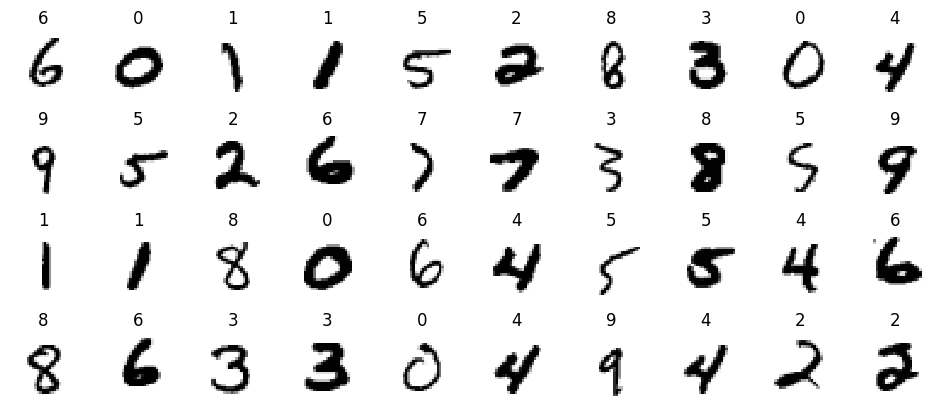

In [5]:
import matplotlib.pyplot as plt
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Limpiamos todo por si hemos estado experimentando antes y ponemos una seed para la reproducibilidad de los resultados

In [5]:
tf.keras.backend.clear_session()
np.random.seed(27)
tf.random.set_seed(27)

## Construcción de las redes neuronales

Vamos a contruir varias redes neuronales para la clasificación. 

Queremos explorar aquellas con **3 y 4 capas ocultas**. 

Usaremos el **learning_rate=1e3** (es el inicial del notebook antes del Fine-Tuning)

Para los demás hiperparámetros vamos a hacer tuning(salvo el learning_rate que lo haremos posteriormente). La idea será considerar redes que tengan distinto número de neuronas en las capas ocultas. Vamos a considerar las opciones de:
- 200, 300 y 500 neuronas para la primera capa oculta. 

Para el resto de capas haremos que tengan menos neuronas (sugerido y argumentado en la literatura). Para ello, utilizaremos un factor f, de manera que si la primera capa tiene $n_1$ neuronas, la segunda tendrá $n_2=f\cdot n_1$, la tercera $n_3=f\cdot n_2=f^2\cdot n_1$ etc. Los factores que consideraremos serán 
- $f=1$ (sin reducción), $f=1/2$ y $f=1/3$.

También consideraremos dos tipos de funciones de activación:
- ReLu y Tangh

In [7]:
import keras_tuner as kt

Creamos el constructor para nuestro modelo

In [19]:
def build_model(hp, learning_rate=0.001):
    # El número de capas: 3 ó 4
    n_hidden = hp.Choice("n_hidden", values=[3,4])
    # El número de neuronas en la primera capa oculta
    n_0 = hp.Choice("n_0", values=[200, 300, 500])
    # Factor de reducción de neuronas en cada capa oculta
    f = hp.Choice("f", values=[1.0, 0.5, 0.33])
    # Otras opciones serían distintas funciones de activación o
    # distintos  optimizadores:
    '''activation = hp.Choice("activation", values=["relu", "tanh"])
    opt = hp.Choice("optimizer", values=["sgd", "adam"])
    if opt == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)'''
    # Fijamos estos hiperparámetros porque si no tardaría mucho
    activation = "relu"
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    # Construimos el modelo en base a la API Sequential
    model = tf.keras.Sequential()
    # Añadimos una capa de aplanado (recordemos que el input son arrays bidimensionales)
    model.add(tf.keras.layers.Flatten())
    # Neuronas para la capa inicial
    neurons = n_0
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_0, activation=activation))
        # Actualizamos el número de neuronas para la siguiente capa
        # El máximo es para que no acabemos con capas de 0 neuronas
        neurons = np.max([np.floor(neurons*f),1]).astype(int)
    # Finalmente hacemos un Softmax a las 10 posibles categorías
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    # Compilamos nuestro modelo
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

El número total de posibilidades son $2\cdot 3\cdot 3=18$. RandomSearch **no repite posibilidades**, así que hacer 18 casos con RandomSearch es equivalente a hacer un GridSearch en todo el espacio de hiperparámetros

In [9]:
hp_possibilities = 18

Como son muchas ejecuciones, vamos a poner solo 5 épocas.

In [ ]:
# Guardamos la búsqueda en my_mnist/my_rnd_search
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=(hp_possibilities+1), overwrite=True,
    directory="my_mnist", project_name="my_rnd_search", seed=27)
random_search_tuner.search(X_train, y_train, epochs=5,
                           validation_data=(X_valid, y_valid))

Trial 17 Complete [00h 00m 38s]
val_accuracy: 0.8961666822433472

Best val_accuracy So Far: 0.9081666469573975
Total elapsed time: 00h 13m 26s


In [ ]:
# Por si quieres cargarla de los datos ya computados
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=(hp_possibilities+1), overwrite=False,
    directory="my_mnist", project_name="my_rnd_search", seed=27)

Reloading Tuner from my_mnist\my_rnd_search\tuner0.json


Vamos a ver cuál es el mejor modelo obtenido para redes de 3 y 4 capas.
Como hemos introducido el número de capas como un hiperparámetro, tenemos que sacar la lista ordenada y filtrar según el número de capas. Hubiera sido más cómodo hacer las búsquedas separadas, pero no es mucho problema

In [40]:
list_hps = random_search_tuner.get_best_hyperparameters(num_trials=hp_possibilities)
list_models = random_search_tuner.get_best_models(num_models=hp_possibilities)

In [41]:
# Primero vamos a por el de 3 neuronas
i_3layers = 0
for i, hps in enumerate(list_hps):
    if(hps.get('n_hidden')==3):
        i_3layers = i
        print(f"El mejor modelo de 3 neuronas es #{i_3layers}")
        print(f" - n_0: {hps.get('n_0')}")
        print(f" - f: {hps.get('f')}")
        #print(f" - activation: {hps.get('activation')}")
        #print(f" - optimizer: {hps.get('optimizer')}")
        break;
best_model_3layers = list_models[i_3layers]
val_loss, val_acc = best_model_3layers.evaluate(X_valid, y_valid)
print(f"Validación accuracy del mejor modelo de 3 neuronas: {val_acc}")

El mejor modelo de 3 neuronas es #2
 - n_0: 500
 - f: 0.33
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9065 - loss: 0.3484
Validación accuracy del mejor modelo de 3 neuronas: 0.906499981880188


In [42]:
# Primero vamos a por el de 3 neuronas
i_4layers = 0
for i, hps in enumerate(list_hps):
    if(hps.get('n_hidden')==4):
        i_4layers = i
        print(f"El mejor modelo de 4 neuronas es #{i_4layers}")
        print(f" - n_0: {hps.get('n_0')}")
        print(f" - f: {hps.get('f')}")
        #print(f" - activation: {hps.get('activation')}")
        #print(f" - optimizer: {hps.get('optimizer')}")
        break;
best_model_4layers = list_models[i_4layers]
val_loss, val_acc = best_model_4layers.evaluate(X_valid, y_valid)
print(f"Validación accuracy del mejor modelo de 4 neuronas: {val_acc}")

El mejor modelo de 4 neuronas es #0
 - n_0: 500
 - f: 0.33
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9082 - loss: 0.3360
Validación accuracy del mejor modelo de 4 neuronas: 0.9081666469573975


Curioso. Los mejores modelos para ambos casos son los de mayor número de neuronas en la primera capa y que decrecen rápidamente en las demás capas ocultas. El de 4 capas ocultas tiene un poco mejor accuracy que el primero, pero no es relevante del todo. Veamos si hay una diferencia muy grande en accuracy con otros, cojamos el modelo mediano (número 9):

In [44]:
# Primero vamos a por el de 3 neuronas
i_median = 8
median_hp = list_hps[i_median]
median_model = list_models[i_median]
print(f"El modelo mediano tiene {median_hp.get('n_hidden')} capas")
print(f" - n_0: {median_hp.get('n_0')}")
print(f" - f: {median_hp.get('f')}")
val_loss, val_acc = median_model.evaluate(X_valid, y_valid)
print(f"Validación {val_acc}")

El modelo mediano tiene 4 capas
 - n_0: 300
 - f: 1.0
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9015 - loss: 0.3636
Validación 0.9014999866485596


Hagamos un plot de las accuracy obtenidas

In [ ]:
# Primero calculamos las accuracy en validación de todos los modelos
accs = []
for i, hps in enumerate(list_hps):
    model = list_models[i]
    val_loss, val_acc = model.evaluate(X_valid, y_valid) 
    accs.append(val_acc)  

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9082 - loss: 0.3360
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9065 - loss: 0.3313
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9065 - loss: 0.3484
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9058 - loss: 0.3520
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9050 - loss: 0.3468
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9047 - loss: 0.3435
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9030 - loss: 0.3559
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9025 - loss: 0.3700
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9015 - loss: 0.3636
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9013 - loss: 0.3635
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9003 - loss: 0.3657
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8992 - loss: 0.3681
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8983 - loss: 0.3747
188/188 ━━━━━━━━━━━━━━━━━

In [ ]:
# Para cada modelo le damos una forma/color/tamaño única dependiendo de hiperparámetros
c = []
m = []
s = []
text = []
for i, hps in enumerate(list_hps):
    if(hps.get('n_hidden')==4):
        c.append('blue')
    else:
        c.append('red') 
    match(hps.get('f')):
        case 1.0:
            m.append('o')
        case 0.5:
            m.append('s')
        case 0.33:
            m.append('^')
    match(hps.get('n_0')):
        case 500:
            s.append(100)
        case 300:
            s.append(50)
        case 200:
            s.append(20)

Text(0, 0.5, 'Validation accuracy')

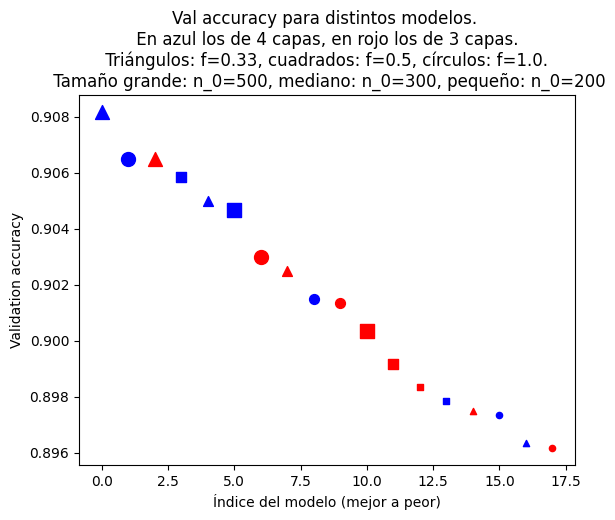

In [115]:
ax = plt.subplot()
for i in range(len(accs)):
    ax.scatter(i,accs[i], c=c[i], s=s[i], marker=m[i])
ax.set_title("Val accuracy para distintos modelos. \n En azul los de 4 capas," \
" en rojo los de 3 capas. \n Triángulos: f=0.33, cuadrados: f=0.5, círculos: f=1.0. " \
    "\n Tamaño grande: n_0=500, mediano: n_0=300, pequeño: n_0=200")
ax.set_xlabel("Índice del modelo (mejor a peor)")
ax.set_ylabel("Validation accuracy")

Como podemos observar, la diferencia en accuracy no es extremadamente relevante. Los modelos de 4 capas funcionan en general un poco mejor, pero casi irrelevante, al menos con un entrenamiento de solo 5 épocas.

Vamos a guardar nuestros dos modelos

In [48]:
best_model_3layers.save("best_model_3layers_5epochs.keras")
best_model_4layers.save("best_model_4layers_5epochs.keras")

Por si quieres cargarlos en un futuro

In [49]:
best_model_3layers = tf.keras.models.load_model("best_model_3layers_5epochs.keras")
best_model_4layers = tf.keras.models.load_model("best_model_4layers_5epochs.keras")

## Tuning Learning Rate

Reiniciamos las seeds

In [14]:
tf.keras.backend.clear_session()
np.random.seed(27)
tf.random.set_seed(27)

Ahora vamos a buscar un learning_rate adecuado, siguiendo el procedimiento descrito en la literatura. Vamos a ir incrementando gradualmente el learning_rate, hasta que nuestro algoritmo diverja. Tomaremos como learning_rate la mitad del learning_rate que nos hizo diverger.

### Preliminares: Creación de clases auxiliares

Creo una clase para poder crear modelos con parámetros concretos a partir de build_model

In [15]:
class FixedHP:
    '''
    Clase para poner valores concretos en build_model
    Ejemplo de uso:
        my_hp = FixedHP(n_hidden=1, n_0=200, f=0.2)
        mymodel = build_model(my_hp)
    '''
    def __init__(self,**kwargs):
        self.mydict = kwargs
    def Int(self, name, **kwargs):
        return self.mydict[name]
    def Choice(self, name, **kwargs):
        return self.mydict[name]

Creo la clase para ir incrementando el learning_rate (extraida del notebook)

In [16]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        '''
        Esto tuve que corregirlo, no me funcionaba con
        la última versión de TF y Keras
        Tengo que usar .assign
        '''
        lr_variable = self.model.optimizer.learning_rate
        current_lr = lr_variable.numpy()
        self.rates.append(current_lr)
        self.losses.append(logs["loss"])
        new_lr = current_lr * self.factor
        lr_variable.assign(new_lr)

### Tuning en el modelo de 3 capas ocultas

Creamos un nuevo modelo con los hiperpárametros que nos dieron
mejor resultado en la búsqueda

In [21]:
best_hp_3layers = FixedHP(n_hidden=3, n_0=500, f=0.33)
new_best_model_3layers = build_model(best_hp_3layers)

Entrenamos un modelo en el cual, con cada batch, aumenta el learning_rate
un 0.5%. Se guarda en la clase expon_lr, después de cada batch el learning_rate
del momento y la pérdida.

In [22]:
expon_lr = ExponentialLearningRate(factor=1.005)
history = new_best_model_3layers.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5494 - loss: nan - val_accuracy: 0.0987 - val_loss: nan


Pintamos la pérdida con respecto al learning_rate al final de cada batch.

Text(0, 0.5, 'Pérdida')

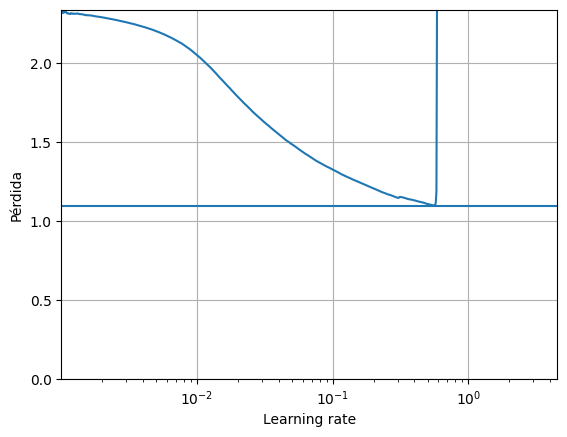

In [23]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Pérdida")

Como se puede observar, nuestro algoritmo tiene un mínimo entorno a 0.6 y después diverge. Vamos a tomar la mitad del learning_rate par al cual se obtuvo la menor pérdida como nuestro learning_rate constante a utilizar para el entrenamiento. Creamos entonces un nuevo modelo preparado para entrenarse con ese learning_rate.

In [24]:
# El learning_rate óptimo
my_lr = expon_lr.rates[np.nanargmin(expon_lr.losses)]/2
# Creamos un nuevo modelo de 3 capas
new_best_model_3layers = build_model(best_hp_3layers)
# Cambiamos su learning_rate al óptimo
new_best_model_3layers.optimizer.learning_rate.assign(my_lr)
print(str(new_best_model_3layers.optimizer.learning_rate.value.value()))

tf.Tensor(0.2803494, shape=(), dtype=float32)


Ejecutamos el entrenamiento. Guardaremos los datos para visualizar con TensorBoard. Usaremos EarlyStopping con paciencia 30 (es decir, si tras 30 épocas no mejora la accuracy, paramos).

Hago algo un poco raro. Mi early_stopping es con respecto a la pérdida, pero
el modelo que guardaré será el de mejor accuracy. Aunque el objetivo que marca
el ejercicio es la accuracy, se minimiza la pérdida por diversas razones (es
diferenciable y por tanto puedes aplicar SGC, es más sensible que la accuracy,
habla de qué tan seguro está el modelo, no solo si acierta etc.). Al estar
mi algoritmo minimizando esa pérdida, el overfitting se producirá cuando
siga aumentando el del train pero no el de validación, por lo que tendrá
sentido parar cuando la pérdida deje de bajar.
Sin embargo, para mí, a posteriori, el mejor modelo será el que a la hora de la verdad tenga  mejor accuracy (independientemente de lo seguro que esté o no el modelo) por lo que lo seleccionaré así. Esta selección tiene sus críticas, como que probablemente sea más variable con respecto al 
cambio de datos (veremos qué pasa luego en el test) y demás, pero no me
parece una opción descabellada.

In [27]:
run_logdir = "my_mnist_logs" + "/run_3layers"
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30)
# Guardamos el mejor de los modelos.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_3layers.keras",
                                                    save_best_only=True,
                                                    monitor='val_accuracy',
                                                    mode='max')
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

# Entrenamos hasta 100 épocas, pero esperamos que el early_stopping lo pare
history = new_best_model_3layers.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb,tensorboard_cb])

Epoch 1/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9863 - loss: 0.0428 - val_accuracy: 0.9767 - val_loss: 0.0946
Epoch 2/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9897 - loss: 0.0316 - val_accuracy: 0.9768 - val_loss: 0.0988
Epoch 3/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9901 - loss: 0.0301 - val_accuracy: 0.9773 - val_loss: 0.0943
Epoch 4/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9931 - loss: 0.0221 - val_accuracy: 0.9763 - val_loss: 0.0998
Epoch 5/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9941 - loss: 0.0195 - val_accuracy: 0.9743 - val_loss: 0.1144
Epoch 6/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9939 - loss: 0.0179 - val_accuracy: 0.9772 - val_loss: 0.0987
Epoch 7/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9963 - loss: 0.0124 - val_accuracy: 0.9795 - val_loss: 0.0934
Epoch 8/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9955 -

In [5]:
new_best_model_3layers = tf.keras.models.load_model("my_mnist_model_3layers.keras")
new_best_model_3layers.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9839 - loss: 0.1097


[0.1096920445561409, 0.9839000105857849]

Hemos obtenido un accuracy superior al 98% en el test

In [8]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
%tensorboard --logdir=./my_mnist_logs

Reusing TensorBoard on port 6006 (pid 10744), started 0:00:06 ago. (Use '!kill 10744' to kill it.)

In [10]:
# A veces a mí no me funciona y tengo que usar lo siguiente:
!py -3.12  "C:\Users\Joaquin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorboard\main.py" --logdir=./my_mnist_logs

^C


Para finalizar incluimos la gráfica de entrenamiento. Véase como la estimación del accuracy en
el train es mayor que en la validación (optimismo, esperable), también como mientras que
el entrenamiento en el train es más estable, en la validación lo es menos pero ambos
suben de manera casi constante hasta que se estabilizan (ya el modelo no entrena más, ha 
alcanzado su mejor versión). Es de destacar la bajada entorno a la época 15, donde
hubo un cambio brusco (el gradiente indicaría de manera errónea) y se corrigió posteriormente.
Esto es algo común y por eso la implementación del stop-loss con una paciencia razonable
es necesaria.

![title](figures/3layers_training.png)

### Tuning en el modelo de 4 capas ocultas

Reinicio la seed, que entrené cada modelo en una instancia distinta

In [30]:
tf.keras.backend.clear_session()
np.random.seed(27)
tf.random.set_seed(27)

Realizamos el mismo procedimiento para 4 capas ocultas. En este caso no
comentamos el procedimiento porque es análogo.

In [31]:
best_hp_4layers = FixedHP(n_hidden=4, n_0=500, f=0.33)
new_best_model_4layers = build_model(best_hp_4layers)

In [32]:
expon_lr = ExponentialLearningRate(factor=1.005)
history = new_best_model_4layers.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5579 - loss: nan - val_accuracy: 0.0987 - val_loss: nan


Text(0, 0.5, 'Loss')

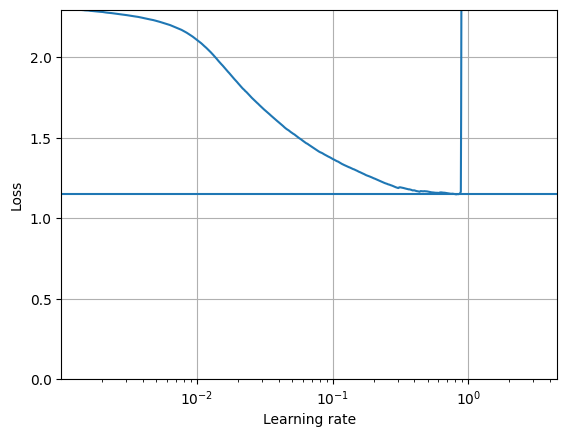

In [33]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [35]:
my_lr = expon_lr.rates[np.nanargmin(expon_lr.losses)]/2
new_best_model_4layers = build_model(best_hp_4layers)
new_best_model_4layers.optimizer.learning_rate.assign(my_lr)
print(str(new_best_model_4layers.optimizer.learning_rate.value.value()))

tf.Tensor(0.40752485, shape=(), dtype=float32)


In [36]:
run_logdir = "my_mnist_logs" + "/run_4layers"
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=30)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_4layers.keras",
                                                    save_best_only=True,
                                                    monitor='val_accuracy',
                                                    mode='max')
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = new_best_model_4layers.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb,tensorboard_cb])

Epoch 1/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9027 - loss: 0.3277 - val_accuracy: 0.9557 - val_loss: 0.1555
Epoch 2/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9666 - loss: 0.1161 - val_accuracy: 0.9680 - val_loss: 0.1142
Epoch 3/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9773 - loss: 0.0765 - val_accuracy: 0.9578 - val_loss: 0.1583
Epoch 4/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9823 - loss: 0.0578 - val_accuracy: 0.9718 - val_loss: 0.1082
Epoch 5/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9867 - loss: 0.0429 - val_accuracy: 0.9722 - val_loss: 0.1113
Epoch 6/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9883 - loss: 0.0387 - val_accuracy: 0.9727 - val_loss: 0.1094
Epoch 7/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9897 - loss: 0.0321 - val_accuracy: 0.9727 - val_loss: 0.1191
Epoch 8/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9917 -

In [38]:
new_best_model_4layers = tf.keras.models.load_model("my_mnist_model_4layers.keras")
new_best_model_4layers.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9839 - loss: 0.1017


[0.10172638297080994, 0.9839000105857849]

Hemos obtenido un accuracy superior al 98% en el test (mismo que el de 3 layers)

In [39]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

El entrenamiento ha sido muy similar al de 3 capas.

![title](figures/3layers_training.png)

## Conclusiones

En esta práctica hemos aprendido a realizar un proceso de entrenamiento, selección y tuning de hiperparámetros de redes neuronales feedforward.

Para ello, hemos considerado el conocido dataset MNIST y por medio de redes neuronales **MLP de 3 y 4 capas ocultas** hemos tratado el problema de clasificación.

Para una primera selección de los hiperparámetros, hemos tomado varios modelos con **distintas anchuras** (tamaño de las capas ocultas), los hemos entrenado poco (hasta 5 épocas) con un learning_rate fijo y hemos seleccionado los mejores. Para estos mejores modelos, hemos buscado un learning_rate adecuado, sugerido en la literatura como la mitad del learning_rate que produce la divergencia del método.

Con dicho learning_rate óptimo los hemos entrenado con early_stopping seleccionando el modelo con mejor accuracy.

Las **diferencias observadas cuando se seleccionaron los modelos no fueron excesivamente significativas**, y en general, los modelos con 4 capas ocultas
parecían tener una accuracy un poco superior a los de 3 (aunque probablemente no estadísticamente significativo). Los modelos óptimos fueron aquellos con una mayor cantidad de neuronas en la capa inicial, pero que a la vez más se reducían en las siguientes capas ocultas. Aquí surge la pregunta de por qué no tiene mayor efectividad mantener las demás capas con muchas neuronas. Esto puede deberse a que realmente una **estructura más piramidal ayuda a la red a capturar las features importantes y no capturar el ruido**, o simplemente es una cuestión más aleatoria y que tiene que ver con la velocidad de convergencia a mismo factor de learning_rate.

El entrenamiento por medio del learning_rate tuneado + early_stopping dio lugar a unos **resultados muy razonables en el test**. Además, no se obtuvo diferencia de accuracy entre los modelos de 3 o 4 capas.
| Capas ocultas | Neuronas capa oculta inicial | Factor reducción en las siguientes capas | Accuracy |
| :--- | :---: | :---: | :---: |
| 3 | 500 | 0.33 | 98.4% |
| 4 | 500 | 0.33 | 98.4% |

Concluimos de esta práctica que incluso redes neuronales simples de 3 o 4 capas, sin que sean redes convolucionales, pueden obtener resultados extremadamente buenos en problemas simples de clasificación de imágenes como el presentado.

#### Observaciones

En general he tenido problema con la reproducibilidad de resultados. Yo estoy menos acostumbrado a tratar con notebook de Python y suelo hacer scripts, por
lo que no suelo tener problema. Aquí use un notebook porque me parece más adecuado para las prácticas. El problema surge cuando vuelves atrás y no ejecutas
las cedas en orden.
He tratado de poner varios "checkpoints" donde incluyo el código:
```python
tf.keras.backend.clear_session()
np.random.seed(27)
tf.random.set_seed(27)
```

de manera que si ejecuto eso y luego todo lo que está debajo en orden, debería ser reproducible.
Sin embargo alguna vez me he encontrado con resultados que me han parecido diferentes, aunque igual ha sido porque no lo he hecho anteriormente
de esa manera. Si el corrector piensa que hay alguna otra aleatoriedad que no estoy reinicializando o algo que esté olvidando agradezco
que me lo haga saber para las siguientes prácticas.